In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
print(tf.config.list_physical_devices('GPU'))

2023-09-26 21:39:53.729995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 21:39:53.845269: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras.optimizers import Adam
import footnet_parallel as ftnet

In [3]:
def IoU(truth, pred):
    intersec = np.logical_and(~np.isnan(truth), ~np.isnan(pred))
    union = np.logical_or(~np.isnan(truth), ~np.isnan(pred))
    return np.sum(intersec)/np.sum(union)

def split_df(_df):
    totalsize = _df.shape[0]
    trainsize, validsize = int(totalsize*0.85**2), int(totalsize*0.85*0.15)
    train_list  = _df[:trainsize]['path'].tolist()
    valid_list = _df[trainsize:(trainsize+validsize)]['path'].tolist()
    test_list = _df[(trainsize+validsize):]['path'].tolist()

    print(f"Train: {len(train_list)} \nVal: {len(valid_list)} \nTest: {len(test_list)}")
    return train_list, valid_list, test_list

combdf = pd.read_csv('../combined_data_set_Sept11_20k.csv')
train_list, valid_list, test_list = split_df(combdf[:])
print(len(train_list), len(valid_list), len(test_list))

Train: 14449 
Val: 2550 
Test: 3001
14449 2550 3001


In [4]:
model = ftnet.build_model(num_var=12)
opt = Adam(lr=1e-5)
model.compile(optimizer=opt, loss='mse')
model.load_weights('exp1/Unet_checkpt_0.59.h5')

2023-09-26 21:39:59.110737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 21:39:59.687244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13163 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [1]:
# for i in range(len(test_list)):
#     outname = 'exp1/predictions/' + test_list[i].split('/')[-1][:-4] + '_prediction.npz'
#     fnow = np.load(test_list[i])
#     pred   = fnow['pred']
#     pred6h = fnow['_6hpred']
#     truth = fnow['obs']
#     lons = fnow['lons']
#     lats = fnow['lats']
#     sitelon = fnow['sitelon']
#     sitelat = fnow['sitelat']
#     tempxy = ftnet.transform_func_6h(pred, pred6h, truth)
#     tempx, truth_log = tempxy[:, :, :-1], tempxy[:, :, -1]
#     pred_log = model.predict(tempx[np.newaxis, :, :, :])
#     pred_log = np.squeeze(pred_log)
    
#     np.savez(outname, truth_log=truth_log, pred_log=pred_log,
#              lons=lons, lats=lats, sitelon=sitelon, sitelat=sitelat,
#              pred=pred, pred6h=pred6h)

In [5]:
import proplot as pplt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")

import cartopy.io.shapereader as shpreader
from mpl_toolkits.axes_grid1 import make_axes_locatable 

reader = shpreader.Reader('../../footnet_emulator_paper/countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

# from skimage.metrics import structural_similarity as ssim
# from sklearn.metrics import mean_squared_error as mse

In [6]:
flist = glob.glob('exp1/predictions/*npz')

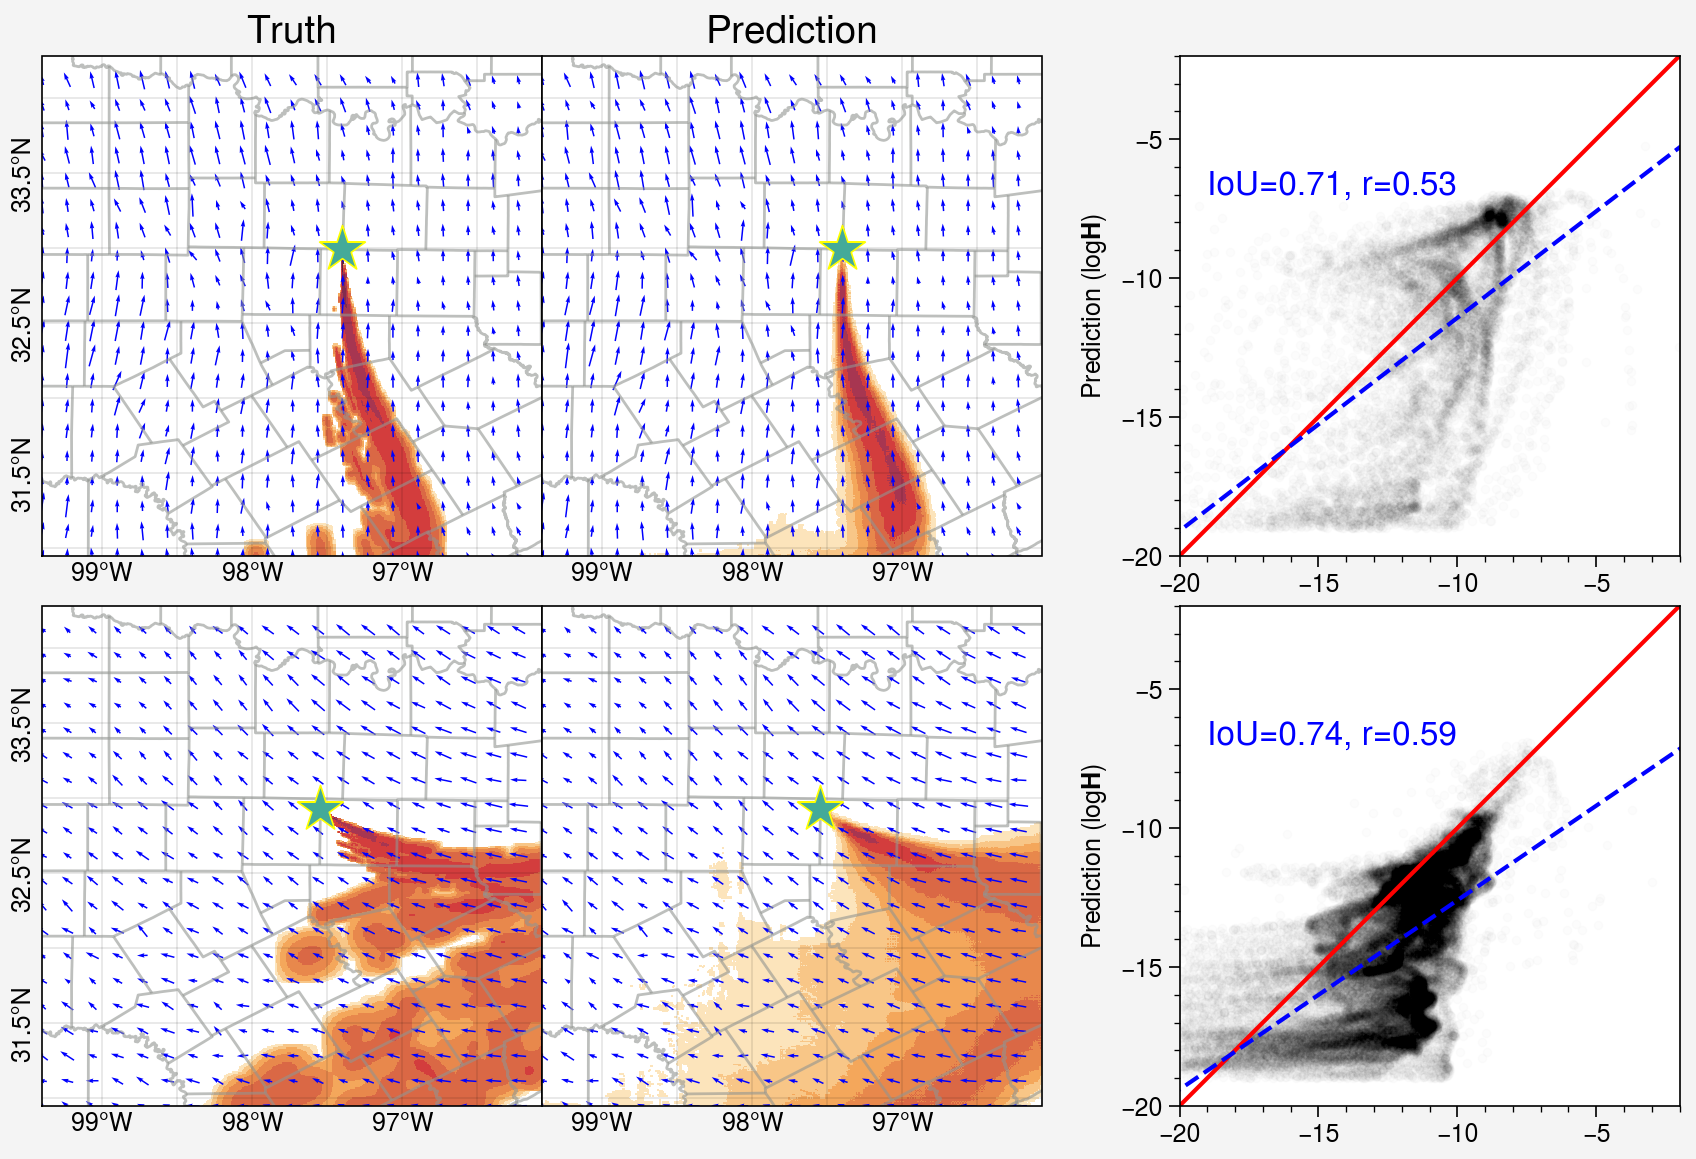

In [12]:
figmax = 0.9*-2.11583259529705

fig = pplt.figure(refwidth=2.5, share=False)
gs = pplt.GridSpec(ncols=3, nrows=2, wspace=[0, 5.5], hspace=2, right=0.66)
markercolor='#44AA99'


fnow = flist[1011]
pred = np.load(fnow)['pred_log']
truth = np.load(fnow)['truth_log']
lons = np.load(fnow)['lons']
lats = np.load(fnow)['lats']
sitelon = np.load(fnow)['sitelon']
sitelat = np.load(fnow)['sitelat']
u = np.load(fnow)['pred'][:, :, 1]
v = np.load(fnow)['pred'][:, :, 2]
truth[truth <= 0] = np.nan
pred[pred <= 1] = np.nan
# u = np.load(fnow)['u10m']
# v = np.load(fnow)['v10m']
truth = truth - 20
pred = pred - 20


ax = fig.subplot(gs[0, 0], proj='cyl', number=1)
ax.pcolormesh(lons, lats, truth, vmax=figmax, vmin=-20, extend='both')
ax.quiver(lons[::20], lats[::20], u[::20, ::20], v[::20, ::20], pivot='mid', color='blue')
ax.scatter(sitelon, sitelat, marker='*', color=markercolor, edgecolor='yellow', s=300, zorder=3)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='grey', lw=1, alpha=0.6)
ax.coastlines(lw=1.5)
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_xticks([-99, -98, -97])
ax.set_xticklabels(['99°W', '98°W', '97°W'])
ax.set_yticks([31.5, 32.5, 33.5])
ax.set_yticklabels(['31.5°N', '32.5°N', '33.5°N'], rotation=90, va='center')
ax.set_title('Truth', fontsize=14)

ax = fig.subplot(gs[0, 1], proj='cyl', number=2)
ax.pcolormesh(lons, lats, pred, vmax=figmax, vmin=-20, extend='both')
ax.quiver(lons[::20], lats[::20], u[::20, ::20], v[::20, ::20], pivot='mid', color='blue')
ax.scatter(sitelon, sitelat, marker='*', color=markercolor, edgecolor='yellow', s=300, zorder=3)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='grey', lw=1, alpha=0.6)
ax.coastlines(lw=1.5)
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_xticks([-99, -98, -97])
ax.set_xticklabels(['99°W', '98°W', '97°W'])
ax.set_title('Prediction', fontsize=14)

pred_nonnan = pred[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]
truth_nonnan = truth[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]

ax = fig.subplot(gs[0, 2])
ax.scatter(truth_nonnan, pred_nonnan, edgecolor='k', facecolor='none', marker='.', alpha=0.01)
_xx = np.arange(-40, 1, 0.5)
ax.plot(_xx, _xx, color='red')
ax.format(xlim=(-20, -2), ylim=(-20, -2), xlabel='Truth (log$\mathbf{H}$)', ylabel='Prediction (log$\mathbf{H}$)', grid=False, xticks=[-20, -15, -10, -5, 0], yticks=[-20, -15, -10, -5, 0])
z = np.polyfit(truth_nonnan, pred_nonnan, 1)
p = np.poly1d(z)
ax.plot(_xx, p(_xx), color='blue', ls='--')
rr = np.corrcoef(truth_nonnan, pred_nonnan)[0, 1]
ax.text(-19, -7, 'IoU=%.2f, r=%.2f'%(IoU(truth, pred), rr), fontsize=12, color='b')

fnow = flist[46]
pred = np.load(fnow)['pred_log']
truth = np.load(fnow)['truth_log']
lons = np.load(fnow)['lons']
lats = np.load(fnow)['lats']
sitelon = np.load(fnow)['sitelon']
sitelat = np.load(fnow)['sitelat']
u = np.load(fnow)['pred'][:, :, 1]
v = np.load(fnow)['pred'][:, :, 2]
truth[truth <= 0] = np.nan
pred[pred <= 1] = np.nan
# u = np.load(fnow)['u10m']
# v = np.load(fnow)['v10m']
truth = truth - 20
pred = pred - 20

ax = fig.subplot(gs[1, 0], proj='cyl', number=1)
ax.pcolormesh(lons, lats, truth, vmax=figmax, vmin=-20, extend='both')
ax.quiver(lons[::20], lats[::20], u[::20, ::20], v[::20, ::20], pivot='mid', color='blue')
ax.scatter(sitelon, sitelat, marker='*', color=markercolor, edgecolor='yellow', s=300, zorder=3)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='grey', lw=1, alpha=0.6)
ax.coastlines(lw=1.5)
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_xticks([-99, -98, -97])
ax.set_xticklabels(['99°W', '98°W', '97°W'])
ax.set_yticks([31.5, 32.5, 33.5])
ax.set_yticklabels(['31.5°N', '32.5°N', '33.5°N'], rotation=90, va='center')

ax = fig.subplot(gs[1, 1], proj='cyl', number=2)
ax.pcolormesh(lons, lats, pred, vmax=figmax, vmin=-20, extend='both')
ax.quiver(lons[::20], lats[::20], u[::20, ::20], v[::20, ::20], pivot='mid', color='blue')
ax.scatter(sitelon, sitelat, marker='*', color=markercolor, edgecolor='yellow', s=300, zorder=3)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='grey', lw=1, alpha=0.6)
ax.coastlines(lw=1.5)
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_xticks([-99, -98, -97])
ax.set_xticklabels(['99°W', '98°W', '97°W'])

pred_nonnan = pred[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]
truth_nonnan = truth[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]

ax = fig.subplot(gs[1, 2])
ax.scatter(truth_nonnan, pred_nonnan, edgecolor='k', facecolor='none', marker='.', alpha=0.01)
_xx = np.arange(-40, 1, 0.5)
ax.plot(_xx, _xx, color='red')
ax.format(xlim=(-20, -2), ylim=(-20, -2), ylabel='Prediction (log$\mathbf{H}$)', grid=False, xticks=[-20, -15, -10, -5, 0], yticks=[-20, -15, -10, -5, 0])
z = np.polyfit(truth_nonnan, pred_nonnan, 1)
p = np.poly1d(z)
ax.plot(_xx, p(_xx), color='blue', ls='--')
rr = np.corrcoef(truth_nonnan, pred_nonnan)[0, 1]
ax.text(-19, -7, 'IoU=%.2f, r=%.2f'%(IoU(truth, pred), rr), fontsize=12, color='b')

plt.savefig('fig2top.png', dpi=400)

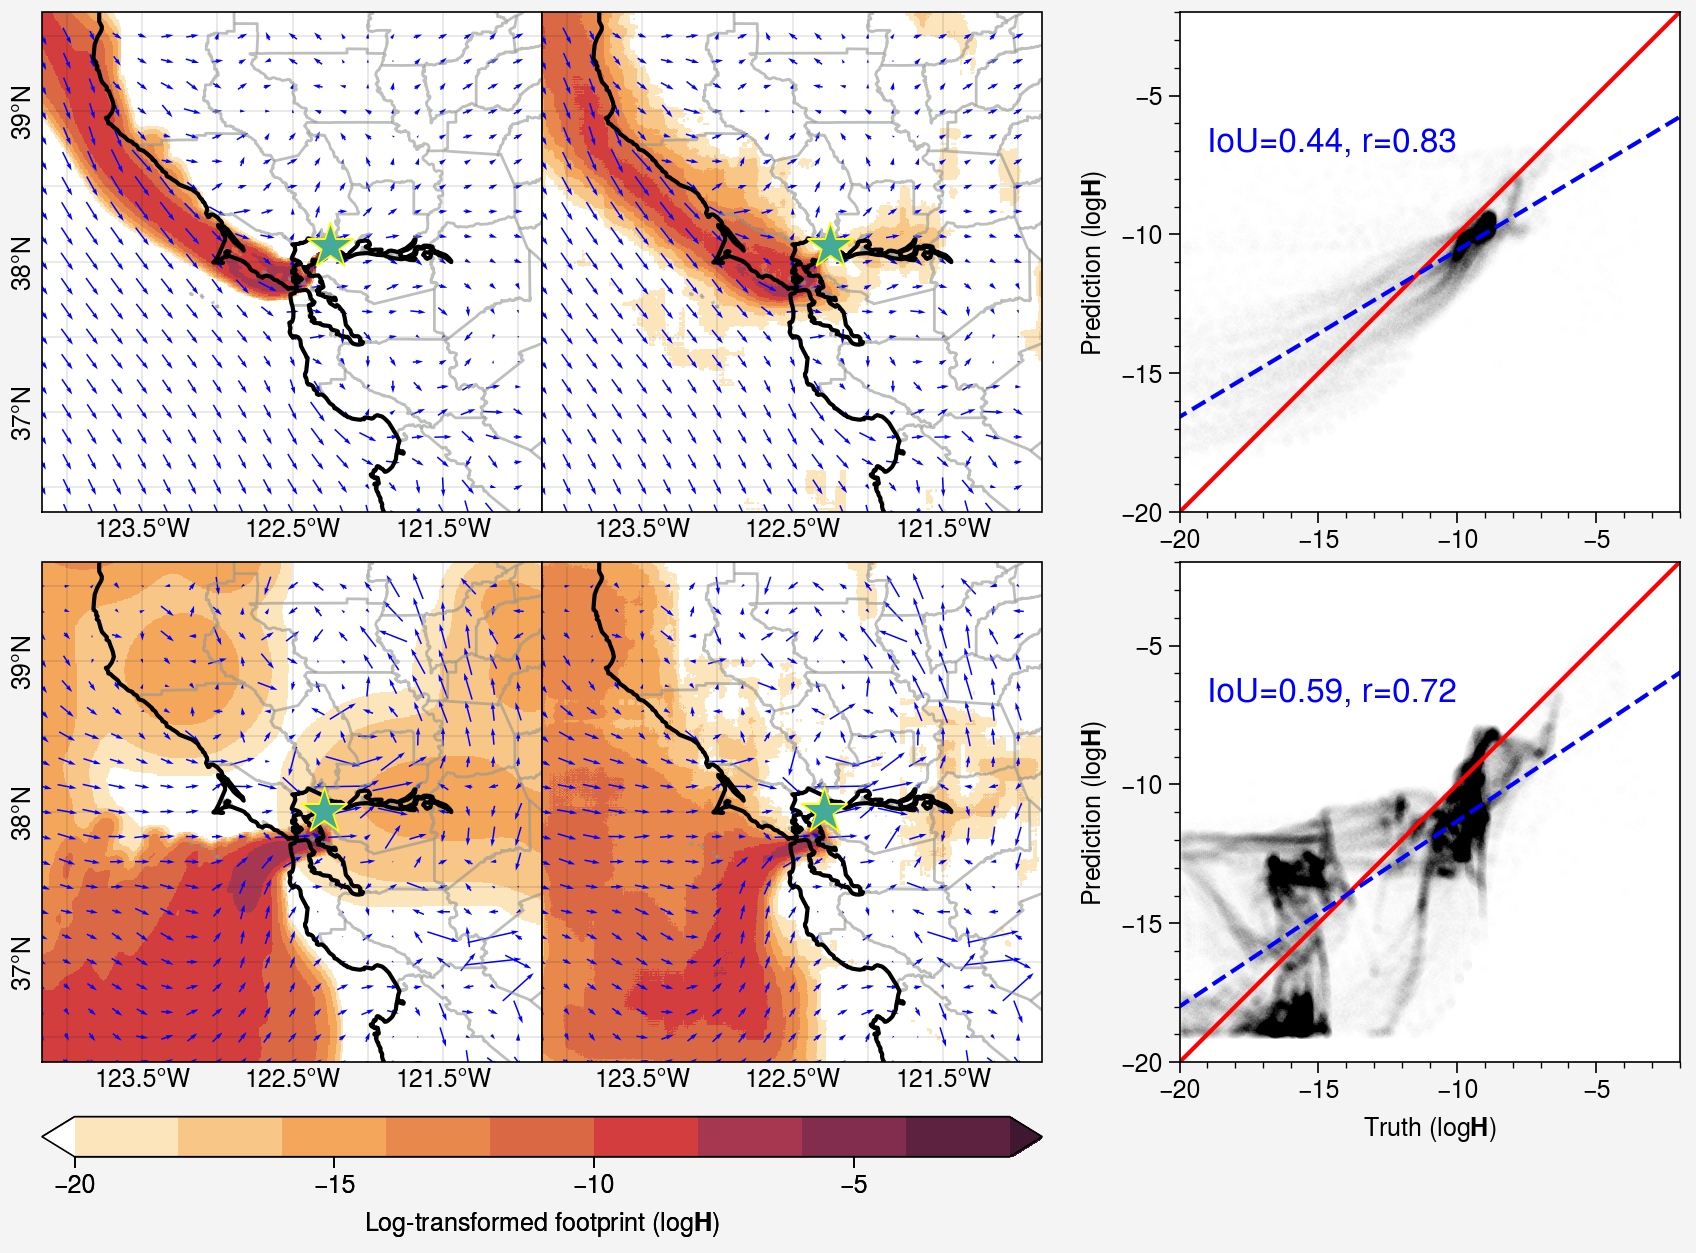

In [20]:
figmax = 0.9*-2.11583259529705

fig = pplt.figure(refwidth=2.5, share=False)
gs = pplt.GridSpec(ncols=3, nrows=2, wspace=[0, 5.5], hspace=2, right=0.66)

markercolor='#44AA99'

fnow = flist[1054]
pred = np.load(fnow)['pred_log']
truth = np.load(fnow)['truth_log']
lons = np.load(fnow)['lons']
lats = np.load(fnow)['lats']
sitelon = np.load(fnow)['sitelon']
sitelat = np.load(fnow)['sitelat']
u = np.load(fnow)['pred'][:, :, 1]
v = np.load(fnow)['pred'][:, :, 2]
truth[truth <= 0] = np.nan
pred[pred <= 1] = np.nan
# u = np.load(fnow)['u10m']
# v = np.load(fnow)['v10m']
truth = truth - 20
pred = pred - 20


ax = fig.subplot(gs[0, 0], proj='cyl', number=1)
ax.pcolormesh(lons, lats, truth, vmax=figmax, vmin=-20, extend='both')
ax.quiver(lons[::20], lats[::20], u[::20, ::20], v[::20, ::20], pivot='mid', color='blue')
ax.scatter(sitelon, sitelat, marker='*', facecolor=markercolor, edgecolor='yellow', s=300, zorder=3)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='grey', lw=1, alpha=0.6)
ax.coastlines(lw=1.5)
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_xticks([-123.5, -122.5, -121.5])
ax.set_xticklabels(['123.5°W', '122.5°W', '121.5°W'])
ax.set_yticks([37, 38, 39])
ax.set_yticklabels(['37°N', '38°N', '39°N'], rotation=90, va='center')

ax = fig.subplot(gs[0, 1], proj='cyl', number=2)
ax.pcolormesh(lons, lats, pred, vmax=figmax, vmin=-20, extend='both')
ax.quiver(lons[::20], lats[::20], u[::20, ::20], v[::20, ::20], pivot='mid', color='blue')
ax.scatter(sitelon, sitelat, marker='*', facecolor=markercolor, edgecolor='yellow', s=300, zorder=3)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='grey', lw=1, alpha=0.6)
ax.coastlines(lw=1.5)
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_xticks([-123.5, -122.5, -121.5])
ax.set_xticklabels(['123.5°W', '122.5°W', '121.5°W'])


pred_nonnan = pred[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]
truth_nonnan = truth[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]

ax = fig.subplot(gs[0, 2])
ax.scatter(truth_nonnan, pred_nonnan, edgecolor='k', facecolor='none', marker='.', alpha=0.005)
_xx = np.arange(-40, 1, 0.5)
ax.plot(_xx, _xx, color='red')
ax.format(xlim=(-20, -2), ylim=(-20, -2), xlabel='Truth (log$\mathbf{H}$)', ylabel='Prediction (log$\mathbf{H}$)', grid=False, xticks=[-20, -15, -10, -5, 0], yticks=[-20, -15, -10, -5, 0])
z = np.polyfit(truth_nonnan, pred_nonnan, 1)
p = np.poly1d(z)
ax.plot(_xx, p(_xx), color='blue', ls='--')
rr = np.corrcoef(truth_nonnan, pred_nonnan)[0, 1]
ax.text(-19, -7, 'IoU=%.2f, r=%.2f'%(IoU(truth, pred), rr), fontsize=12, color='b')


fnow = flist[1032] #1059
pred = np.load(fnow)['pred_log']
truth = np.load(fnow)['truth_log']
lons = np.load(fnow)['lons']
lats = np.load(fnow)['lats']
sitelon = np.load(fnow)['sitelon']
sitelat = np.load(fnow)['sitelat']
u = np.load(fnow)['pred'][:, :, 1]
v = np.load(fnow)['pred'][:, :, 2]
truth[truth <= 0] = np.nan
pred[pred <= 1] = np.nan
# u = np.load(fnow)['u10m']
# v = np.load(fnow)['v10m']
truth = truth - 20
pred = pred - 20


ax = fig.subplot(gs[1, 0], proj='cyl', number=1)
ax.pcolormesh(lons, lats, truth, vmax=figmax, vmin=-20, extend='both')
ax.quiver(lons[::20], lats[::20], u[::20, ::20], v[::20, ::20], pivot='mid', color='blue')
ax.scatter(sitelon, sitelat, marker='*', facecolor=markercolor, edgecolor='yellow', s=300, zorder=3)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='grey', lw=1, alpha=0.6)
ax.coastlines(lw=1.5)
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_xticks([-123.5, -122.5, -121.5])
ax.set_xticklabels(['123.5°W', '122.5°W', '121.5°W'])
ax.set_yticks([37, 38, 39])
ax.set_yticklabels(['37°N', '38°N', '39°N'], rotation=90, va='center')

ax = fig.subplot(gs[1, 1], proj='cyl', number=2)
m = ax.pcolormesh(lons, lats, pred, vmax=figmax, vmin=-20, extend='both')
ax.quiver(lons[::20], lats[::20], u[::20, ::20], v[::20, ::20], pivot='mid', color='blue')
ax.scatter(sitelon, sitelat, marker='*', facecolor=markercolor, edgecolor='yellow', s=300, zorder=3)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='grey', lw=1, alpha=0.6)
ax.coastlines(lw=1.5)
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_xticks([-123.5, -122.5, -121.5])
ax.set_xticklabels(['123.5°W', '122.5°W', '121.5°W'])


pred_nonnan = pred[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]
truth_nonnan = truth[np.where(np.logical_and(~np.isnan(truth), ~np.isnan(pred)))]

ax = fig.subplot(gs[1, 2])
ax.scatter(truth_nonnan, pred_nonnan, edgecolor='k', facecolor='none', marker='.', alpha=0.005)
_xx = np.arange(-40, 1, 0.5)
ax.plot(_xx, _xx, color='red')
ax.format(xlim=(-20, -2), ylim=(-20, -2), xlabel='Truth (log$\mathbf{H}$)', ylabel='Prediction (log$\mathbf{H}$)', grid=False, xticks=[-20, -15, -10, -5, 0], yticks=[-20, -15, -10, -5, 0])
z = np.polyfit(truth_nonnan, pred_nonnan, 1)
p = np.poly1d(z)
ax.plot(_xx, p(_xx), color='blue', ls='--')
rr = np.corrcoef(truth_nonnan, pred_nonnan)[0, 1]
ax.text(-19, -7, 'IoU=%.2f, r=%.2f'%(IoU(truth, pred), rr), fontsize=12, color='b')

fig.colorbar(m, label='Log-transformed footprint (log$\mathbf{H}$)', ticks=[-20, -15, -10, -5, 0], loc='b', cols=(1,2))

plt.savefig('fig2bot.png', dpi=400)